# Looking at fastai's test_dl

> Examining and adapting `test_dl` to understand both how it works and how to leverage it in any situation

* toc: true
* badges: true
* comments: true

---
This blog is also a Jupyter notebook available to run from the top down. There will be code snippets that you can then run in any environment. In this section I will be posting what version of fastai2 and fastcore I am currently running at the time of writing this:

* `fastai2`: 0.0.17
* `fastcore`: 0.1.18

---

## The `test_dl`, what is it? How does it work? How can I customize it?

In this article we'll be exploring fastai2's `test_dl` method, where it comes from, what it is actually performing, and how we can utilize it on our models.

## Vision

We'll start with a Vision based problem, the standard PETS dataset. Let's quickly build some `DataLoaders` via our `DataBlock`:

In [2]:
from fastai2.vision.all import *

In [109]:
path = untar_data(URLs.PETS)
fnames = get_image_files(path/'images')
pat = r'(.+)_\d+.jpg$'

batch_tfms = [*aug_transforms(size=224, max_warp=.9), Normalize.from_stats(*imagenet_stats)]
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
bs=64

dls = ImageDataLoaders.from_name_re(path, fnames, pat, batch_tfms=batch_tfms, 
                                   item_tfms=item_tfms, bs=bs)

> I've made our max warp extremely high here, so we can see the difference between the train and validation set

Now there's a few key points of interest I'd like to point out here. Every augmentation transform has the chance to provide special directions if we are looking at the validation set. What does it mean in this case? Let's take a look. 

First, our training set:

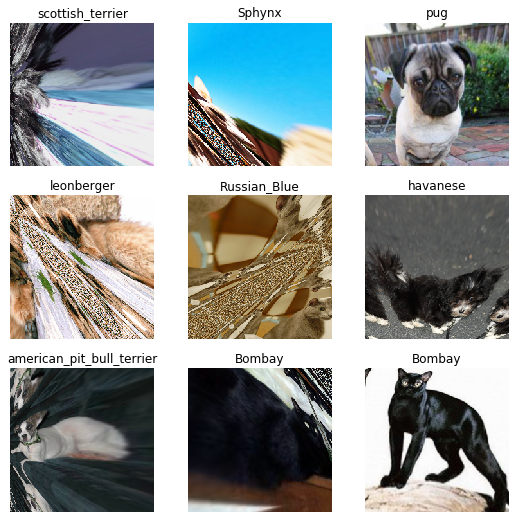

In [6]:
dls.train.show_batch()

And now the validation:

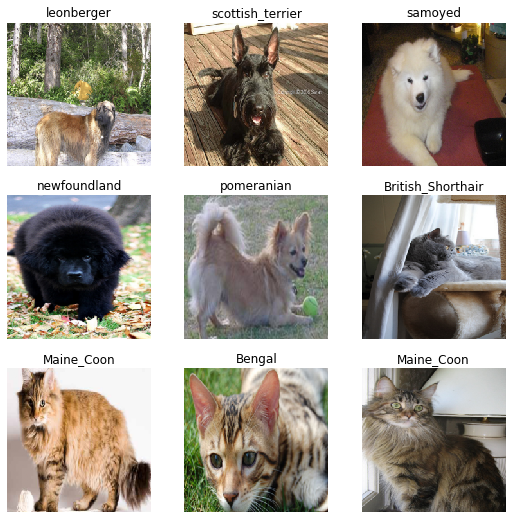

In [7]:
dls.valid.show_batch()

As we can see, our heavy training augmentation didn't get applied to the validation set. Which is good! This is what we want. Now, why do we care about this though? Time to dig into the `test_dl` method:

## test_dl

Now if we consider what `test_dl` sounds like, we would presume it would be to make a test `DataLoader` (just like our training and validation `DataLoaders` from a moment ago) from new data that we do not wish to train on (ala inference). Let's see how the code stacks up:

In [9]:
@delegates(TfmdDL.__init__)
@patch
def test_dl(self:DataLoaders, test_items, rm_type_tfms=None, with_labels=False, **kwargs):
    "Create a test dataloader from `test_items` using validation transforms of `dls`"
    test_ds = test_set(self.valid_ds, test_items, rm_tfms=rm_type_tfms, with_labels=with_labels
                      ) if isinstance(self.valid_ds, (Datasets, TfmdLists)) else test_items
    return self.valid.new(test_ds, **kwargs)

Great! So... what on earth does this actually mean? Let's walk through it line by line.

First, the odd `fastcore` and `TypeDispatch` bits. `@delgates` ensures that when we press tab when calling our `test_dl` method in `DataLoaders`, it will show the same initialization parameters as `TfmdDL`.

> Later we will see how this adjusts to different `DataLoader` types, so don't fear about it just being available to the `TfmdDL`!

Next we have an `@patch` method, all this really means is we can define functions for classes outside their actual class definition, allowing us to modify and extend classes on the fly. 

Now let's move onto the parameters:

* `self:DataLoaders`: This is for `@patch`, the type (`DataLoaders`) tells it what we're patching onto
* `test_items`: These, as you can imagine, simply is a collection of items that we want our `test_dl` to have
* `rm_type_tfms`: we'll look into this more in-depth later but we can remove our `type_tfms` from our `DataLoader` if we expect our inputs to change
* `with_labels`: If we expect our data to be labelled in the *same way* our training data was labelled, we can optionally label our data. 

Now that we know all of this, what actually happens?

So first we need to make a `Dataset`, just as we would with any `fastai` pipeline. In our case we have a special `test_set` function, which takes an input from a `Dataset`, some test items, and the rest of our parameters and generates a *new* dataset based on the input dataset. Since in production we want everything to mimic the validation set, we pass in `dls.valid_ds`

We'll briefly look at the code, however it can be intimidating so don't be scared!

In [12]:
def test_set(dsets, test_items, rm_tfms=None, with_labels=False):
    "Create a test set from `test_items` using validation transforms of `dsets`"
    if isinstance(dsets, Datasets):
        tls = dsets.tls if with_labels else dsets.tls[:dsets.n_inp]
        test_tls = [tl._new(test_items, split_idx=1) for tl in tls]
        if rm_tfms is None: rm_tfms = [tl.infer_idx(get_first(test_items)) for tl in test_tls]
        else:               rm_tfms = tuplify(rm_tfms, match=test_tls)
        for i,j in enumerate(rm_tfms): test_tls[i].tfms.fs = test_tls[i].tfms.fs[j:]
        return Datasets(tls=test_tls)
    elif isinstance(dsets, TfmdLists):
        test_tl = dsets._new(test_items, split_idx=1)
        if rm_tfms is None: rm_tfms = dsets.infer_idx(get_first(test_items))
        test_tl.tfms.fs = test_tl.tfms.fs[rm_tfms:]
        return test_tl
    else: raise Exception(f"This method requires using the fastai library to assemble your data. Expected a `Datasets` or a `TfmdLists` but got {dsets.__class__.__name__}")

All we're really doing here is first taking in our base set (as I mentioned earlier), potentially removing any of the type transforms, and then building a new dataset based on our old one!

We'll quickly build two here, with the first keeping our `type_tfms` and the second removing them to see the difference.

Let's grab some filenames:

In [14]:
fns_small = fnames[:10]; fns_small[0]

Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/Birman_132.jpg')

Next we'll try to make some test sets:

In [20]:
a = test_set(dls.valid_ds, fns_small); a

(#10) [(PILImage mode=RGB size=500x343,),(PILImage mode=RGB size=225x300,),(PILImage mode=RGB size=500x375,),(PILImage mode=RGB size=225x300,),(PILImage mode=RGB size=359x500,),(PILImage mode=RGB size=375x500,),(PILImage mode=RGB size=375x500,),(PILImage mode=RGB size=375x500,),(PILImage mode=RGB size=500x331,),(PILImage mode=RGB size=262x246,)]

We can see that we have a collection of PIL images. You may notice though that they are tuples. Why? This is so we can cover a scenario in-which we have labels, like below:

In [21]:
b = test_set(dls.valid_ds, fns_small, with_labels=True); b

(#10) [(PILImage mode=RGB size=500x343, TensorCategory(2)),(PILImage mode=RGB size=225x300, TensorCategory(28)),(PILImage mode=RGB size=500x375, TensorCategory(22)),(PILImage mode=RGB size=225x300, TensorCategory(1)),(PILImage mode=RGB size=359x500, TensorCategory(29)),(PILImage mode=RGB size=375x500, TensorCategory(4)),(PILImage mode=RGB size=375x500, TensorCategory(14)),(PILImage mode=RGB size=375x500, TensorCategory(3)),(PILImage mode=RGB size=500x331, TensorCategory(33)),(PILImage mode=RGB size=262x246, TensorCategory(1))]

Great! Now what about that `rm_type_tfm` thingy? Let's try it. We can pass in a 0 or a 1, let's explore what each does:

We'll just use the first two lines, as this gets us to the point we want:

In [35]:
tls = dls.valid_ds.tls[:dls.valid_ds.n_inp]
test_tls = [tl._new(fns_small, split_idx=1) for tl in tls]

In [46]:
test_tls[0].tfms.fs

(#2) [noop: (object,object) -> noop ,PILBase.create: (bytes,object) -> create
(ndarray,object) -> create
(Tensor,object) -> create
(str,object) -> create
(Path,object) -> create ]

So as we can see we have a few different transforms here. If we want to remove our `PILBase.create`, we could simply pass `idx=2`:
> An index of 0 won't remove anything

In [55]:
c = test_set(dls.valid_ds, fns_small, rm_tfms=2); c.tfms.fs

(#0) []

And if we look at C now:

In [57]:
c

(#10) [(Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/Birman_132.jpg'),),(Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/pomeranian_116.jpg'),),(Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/havanese_94.jpg'),),(Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/Bengal_166.jpg'),),(Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/pug_30.jpg'),),(Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/British_Shorthair_16.jpg'),),(Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/basset_hound_45.jpg'),),(Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/Bombay_67.jpg'),),(Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/shiba_inu_78.jpg'),),(Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/Bengal_157.jpg'),)]

It's just paths! However, can we pass our own in, if say our data input suddenly changes? Let's try. For now this will require a little hack. First let's remove our `PILImage` from our `dls`:

In [128]:
dls = ImageDataLoaders.from_name_re(path, fnames, pat, batch_tfms=batch_tfms, 
                                   item_tfms=item_tfms, bs=bs)

In [134]:
dls.valid_ds.tls[0].tfms = Pipeline()

Now if we try it, it will fail:

In [135]:
d = test_set(dls.valid_ds, fns_small); d

(#10) [(Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/Birman_132.jpg'),),(Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/pomeranian_116.jpg'),),(Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/havanese_94.jpg'),),(Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/Bengal_166.jpg'),),(Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/pug_30.jpg'),),(Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/British_Shorthair_16.jpg'),),(Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/basset_hound_45.jpg'),),(Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/Bombay_67.jpg'),),(Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/shiba_inu_78.jpg'),),(Path('/home/ml1/.fastai/data/oxford-iiit-pet/images/Bengal_157.jpg'),)]

Now if we simply override it (we override 0 for the input and 1 for the label):

In [136]:
new_pipe = Pipeline(PILImage.create); new_pipe

Pipeline: PILBase.create

In [137]:
dls.valid_ds.tls[0].tfms = new_pipe

In [138]:
e = test_set(dls.valid_ds, fns_small); e

(#10) [(PILImage mode=RGB size=500x343,),(PILImage mode=RGB size=225x300,),(PILImage mode=RGB size=500x375,),(PILImage mode=RGB size=225x300,),(PILImage mode=RGB size=359x500,),(PILImage mode=RGB size=375x500,),(PILImage mode=RGB size=375x500,),(PILImage mode=RGB size=375x500,),(PILImage mode=RGB size=500x331,),(PILImage mode=RGB size=262x246,)]

We can see we have it back! You can use this to override anything, such as if you were to want to grab the name from a column. We'll do a quick example:

In [139]:
df = pd.DataFrame(columns=['fname'])
df['fname'] = fns_small

In [140]:
df.head()

,fname
0,/home/ml1/.fastai/data/oxford-iiit-pet/images/Birman_132.jpg
1,/home/ml1/.fastai/data/oxford-iiit-pet/images/pomeranian_116.jpg
2,/home/ml1/.fastai/data/oxford-iiit-pet/images/havanese_94.jpg
3,/home/ml1/.fastai/data/oxford-iiit-pet/images/Bengal_166.jpg
4,/home/ml1/.fastai/data/oxford-iiit-pet/images/pug_30.jpg


Now of course we weren't designed to work with this, so let's build a new `Pipeline`:

In [141]:
p = Pipeline([ColReader('fname'), PILImage.create])

Let's test it out:

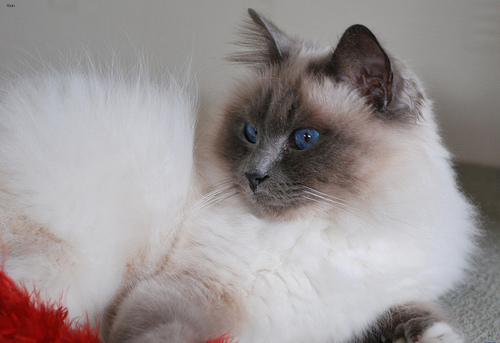

In [142]:
p(df.iloc[0])

Great! Let's try that overriding method one more time:

In [143]:
dls.valid_ds.tls[0].tfms = p

In [155]:
dls.valid_ds.tls[0].types.insert(0, pd.Series)

Note that this time since we're expecting a different type than before, we need to tell fastai to accept a `pd.Series` input! Just for clarity, here is what it was before:

In [157]:
dls.valid_ds.tls[0].types[1:]

[pathlib.PosixPath,
 (pathlib.Path, str, torch.Tensor, numpy.ndarray, bytes),
 fastai2.vision.core.PILImage]

Showing that fastai wanted a Path, anything that PILImage could create with, and eventually a PILImage (great debugging TIL!)

Now let's get back to that test set. Does that work?

In [158]:
f = test_set(dls.valid_ds, df);

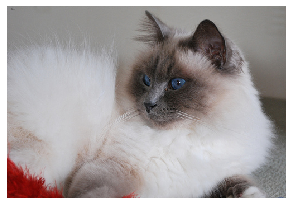

In [161]:
f[0][0].show()

There it is! Great! So now we know how to *completely* customize `test_dl` to not only accept a different input pipeline, but we also understand what it is doing in the background too!

And of course we've only looked at it from a `Dataset` level, lets dig into the `DataLoader` part.

## DataLoader

Our `DataLoader` takes our newly created `Dataset` and applies any validation-set transforms present before pushing it all to a new `DataLoader`. As we can imagine, it's based off the validation `DataLoader` and looks similar to before, with the one line in question being:

In [163]:
self.valid.new(test_ds, **kwargs)

Now what can we pass to those kwargs? Any new transforms you want present. Remember this is *not* like our type transforms, that won't work here and needs our workaround. What we *can* do is override our batch size wanted, the `item_tfms`, `batch_tfms`, if we want it shuffled, etc. 

What will then happen is for all of our transforms, we will run their *validation counterpart only*. For vision remember we saw that it did not apply the Warp transform. There are a few other bits and pieces, such as crops will only center crop. I invite you to go explore the [augmentation](http://dev.fast.ai/vision.augment) docs and [source code](https://github.com/fastai/fastai2/blob/master/fastai2/vision/augment.py) to see how it all works under the hood. And of course, this all will immediatly stem from a call to:

In [164]:
test_dl = dls.test_dl(df)

/home/ml1/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


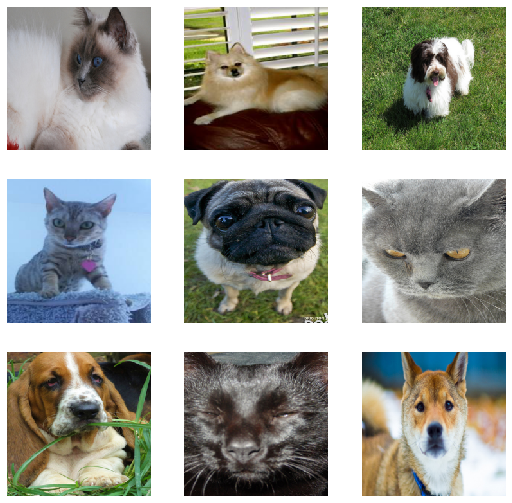

In [165]:
test_dl.show_batch()

## But what happens if I've exported my DataLoaders?

If you choose to either do `learn.export` or pickle the dataloaders themselves, export will actually create a "draft" `DataLoader`, keeping the pipelines in-place while getting rid of any data present. This allows us to then utilize the same transform pipeline in production very efficiently:

In [166]:
def export(self:Learner, fname='export.pkl', pickle_protocol=2):
    "Export the content of `self` without the items and the optimizer state for inference"
    if rank_distrib(): return # don't export if slave proc
    self.dl = None
    old_dbunch = self.dls
    self.dls = self.dls.new_empty() # Right here! 
    state = self.opt.state_dict() if self.opt is not None else None
    self.opt = None
    with warnings.catch_warnings():
        #To avoid the warning that come from PyTorch about model not being checked
        warnings.simplefilter("ignore")
        torch.save(self, self.path/fname, pickle_protocol=pickle_protocol)
    self.create_opt()
    if state is not None: self.opt.load_state_dict(state)
    self.dls = old_dbunch

Which is done via the call to `self.dls.new_empty()`

## Cool, how does it differ in other types?

Let's take a look, first at Tabular then at Text:

In [167]:
from fastai2.tabular.all import *

Tabular's `test_dl` (which stems from `TabularDataLoaders.test_dl`) looks like so:

In [169]:
def test_dl(self, test_items, rm_type_tfms=None, **kwargs):
    to = self.train_ds.new(test_items)
    to.process()
    return self.valid.new(to, **kwargs)

Let's talk quickly about what's happening here. For those familiar with the tabular API, you may recall that `fastai` uses the `TabularPandas` to generate our dataset and apply preprocessing. We follow the same principal as earlier, creating a new `TabularPandas` based on the *training set* (as all our pre-processing statistics are based on the training data), we apply them to the dataset via `to.process()`, before finally creating a new validation `DataLoader` like before. 

What about text?

In [170]:
from fastai2.text.all import *

In [171]:
def test_dl(self:DataLoaders, test_items, rm_type_tfms=None, with_labels=False, **kwargs):
    "Create a test dataloader from `test_items` using validation transforms of `dls`"
    test_ds = test_set(self.valid_ds, test_items, rm_tfms=rm_type_tfms, with_labels=with_labels
                      ) if isinstance(self.valid_ds, (Datasets, TfmdLists)) else test_items
    return self.valid.new(test_ds, **kwargs)

Since the Text API is the same as the Vision API, nothing is different here!

## Closing Remarks

I hope this helps some of you further understand how to use the `test_dl` in both a production environment and your own testing as you're working on your deep learning models. The latency in how `fastai` generates these datasets is extremely efficent (trust me, I tried to speed it up myself) and highly adaptable (with some work). Thanks for reading!